## Descripción del proyecto
Trabajas en una empresa emergente que vende productos alimenticios. Debes investigar el comportamiento del usuario para la aplicación de la empresa

### Objetivo:  
Los usuarios se dividen en tres grupos: dos grupos de control obtienen las fuentes antiguas y un grupo de prueba obtiene las nuevas. Descubre qué conjunto de fuentes produce mejores resultados.

### Etapas 
 
El proyecto consistirá en cinco etapas:
 1. Abrir el archivo de datos y leer la información general
 2. Preparar los datos para el análisis
 3. Estudiar y comprobar los datos
 4. Estudiar el embudo de eventos
 5. Estudiar los resultados del experimento

# Descripción de los datos:

Cada entrada de registro es una acción de usuario o un evento.

- EventName: nombre del evento.
- DeviceIDHash: identificador de usuario unívoco.
- EventTimestamp: hora del evento.
- ExpId: número de experimento: 246 y 247 son los grupos de control, 248 es el grupo de prueba.

# Etapa 1 Abrir el archivo de datos y leer la información general

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from plotly import graph_objects as go
import scipy.stats as stats
import math as mth
from scipy import stats as st
import numpy as np

In [2]:
try:
  logs = pd.read_csv("/datasets/logs_exp_us.csv", sep = '\t')


except:
    logs = pd.read_csv("/content/logs_exp_us.csv", sep = '\t')

In [3]:
logs.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [4]:
print(logs.info())
print('-----------------------------------------------------------------------------------')
print(logs.describe())
print('-----------------------------------------------------------------------------------')
print(logs.describe(include=object))
print('-----------------------------------------------------------------------------------')
print('Datos duplicados',logs.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135312 entries, 0 to 135311
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       135312 non-null  object
 1   DeviceIDHash    135312 non-null  int64 
 2   EventTimestamp  135312 non-null  int64 
 3   ExpId           135312 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 4.1+ MB
None
-----------------------------------------------------------------------------------
       DeviceIDHash  EventTimestamp          ExpId
count  1.353120e+05    1.353120e+05  135312.000000
mean   4.680625e+18    1.564777e+09     247.034646
std    2.646517e+18    1.005943e+05       0.823393
min    6.922444e+15    1.564030e+09     246.000000
25%    2.449862e+18    1.564684e+09     246.000000
50%    4.694015e+18    1.564767e+09     247.000000
75%    6.932517e+18    1.564852e+09     248.000000
max    9.222603e+18    1.564941e+09     248.000000
----------------------

# Conclusión 

primera parte, tenemos 413 datos duplicafos que tenemos que eliminar, ademas de tener diferentes formatos en los nombres de las columna, algo que tambien se debe solucionar y el formato de la columna Eventtimetamp tambien se debe corregir, para hacer mas facil nuestro analisis 

# Etapa 2 Preparar los datos para el análisis

In [5]:
# Eliminación de datos nulo
logs = logs.drop_duplicates().reset_index(drop= True)

In [6]:
logs.duplicated().sum()

0

In [7]:
# Cambio de nombres de las columnas 
logs.columns = ['nombre', 'dispositivo', 'tiempo', 'expid']

In [8]:
logs.head()

,nombre,dispositivo,tiempo,expid
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [9]:
logs['nombre'].unique()

array(['MainScreenAppear', 'PaymentScreenSuccessful', 'CartScreenAppear',
       'OffersScreenAppear', 'Tutorial'], dtype=object)

In [10]:
logs['nombre'] = logs['nombre'].str.lower()

In [11]:
logs['nombre'].unique()

array(['mainscreenappear', 'paymentscreensuccessful', 'cartscreenappear',
       'offersscreenappear', 'tutorial'], dtype=object)

In [12]:
# Cambio de las variables en la columna nombre 
logs['nombre'] = logs['nombre'].replace('mainscreenappear','pantalla_principal').replace('paymentscreensuccessful','pago_exitoso').replace('cartscreenappear','carro_compra').replace('offersscreenappear', 'pantalla_oferta')

In [13]:
logs['nombre'].unique()

array(['pantalla_principal', 'pago_exitoso', 'carro_compra',
       'pantalla_oferta', 'tutorial'], dtype=object)

In [14]:
# ordenar la columna tiempo 
logs['tiempo'] = pd.to_datetime(logs['tiempo'], unit='s')

In [15]:
logs.head()

,nombre,dispositivo,tiempo,expid
0,pantalla_principal,4575588528974610257,2019-07-25 04:43:36,246
1,pantalla_principal,7416695313311560658,2019-07-25 11:11:42,246
2,pago_exitoso,3518123091307005509,2019-07-25 11:28:47,248
3,carro_compra,3518123091307005509,2019-07-25 11:28:47,248
4,pago_exitoso,6217807653094995999,2019-07-25 11:48:42,248


In [16]:
# Creación de columna fecha 
logs['fecha'] = logs['tiempo'].dt.date

In [17]:
logs.head()

,nombre,dispositivo,tiempo,expid,fecha
0,pantalla_principal,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,pantalla_principal,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,pago_exitoso,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
3,carro_compra,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
4,pago_exitoso,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25


# Etapa 3 Estudiar y comprobar los datos

¿Cuántos eventos hay en los registros?

In [18]:
logs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135052 entries, 0 to 135051
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   nombre       135052 non-null  object        
 1   dispositivo  135052 non-null  int64         
 2   tiempo       135052 non-null  datetime64[ns]
 3   expid        135052 non-null  int64         
 4   fecha        135052 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 5.2+ MB


In [19]:
logs['nombre'].value_counts()

pantalla_principal    63733
pantalla_oferta       26489
carro_compra          24690
pago_exitoso          19459
tutorial                681
Name: nombre, dtype: int64

Hay 5 eventos en los registros, teniendo mas el evento pantalla_principal con un total de 119.101 registros

¿Cuántos usuarios y usuarias hay en los registros?

In [20]:
logs.head()

,nombre,dispositivo,tiempo,expid,fecha
0,pantalla_principal,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,pantalla_principal,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,pago_exitoso,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
3,carro_compra,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
4,pago_exitoso,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25


In [21]:
logs['dispositivo'].nunique()

6576

La cantidad de usuarios son 7.552

¿Cuál es el promedio de eventos por usuario?

In [22]:
logs.head()

,nombre,dispositivo,tiempo,expid,fecha
0,pantalla_principal,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,pantalla_principal,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,pago_exitoso,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
3,carro_compra,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
4,pago_exitoso,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25


In [23]:
evento = logs.groupby('dispositivo')['nombre'].count().mean()
evento 

20.537104622871045

el promedio de usuarios por evento es 32

¿Qué periodo de tiempo cubren los datos? Encuentra la fecha máxima y mínima. Traza un histograma por fecha y hora. ¿Puedes tener seguridad de que tienes datos igualmente completos para todo el periodo? Los eventos más antiguos podrían terminar en los registros de algunos usuarios o usuarias por razones técnicas y esto podría sesgar el panorama general. Encuentra el momento en el que los datos comienzan a estar completos e ignora la sección anterior. ¿Qué periodo representan realmente los datos?

In [24]:
print(logs.tiempo.min())
print(logs.tiempo.max())

2019-07-25 04:43:36
2019-08-04 17:46:37


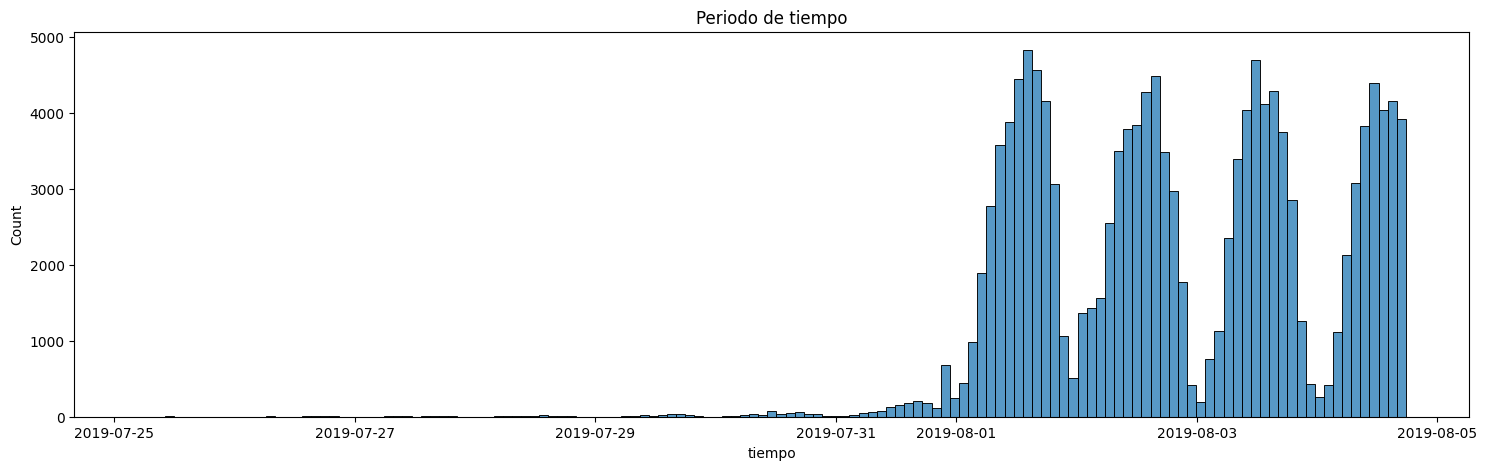

In [25]:
plt.figure(figsize=(18,5))
plt.title('Periodo de tiempo')
sns.histplot(logs, x='tiempo');

In [26]:
df = logs.query('tiempo >= "2019-08-01"')

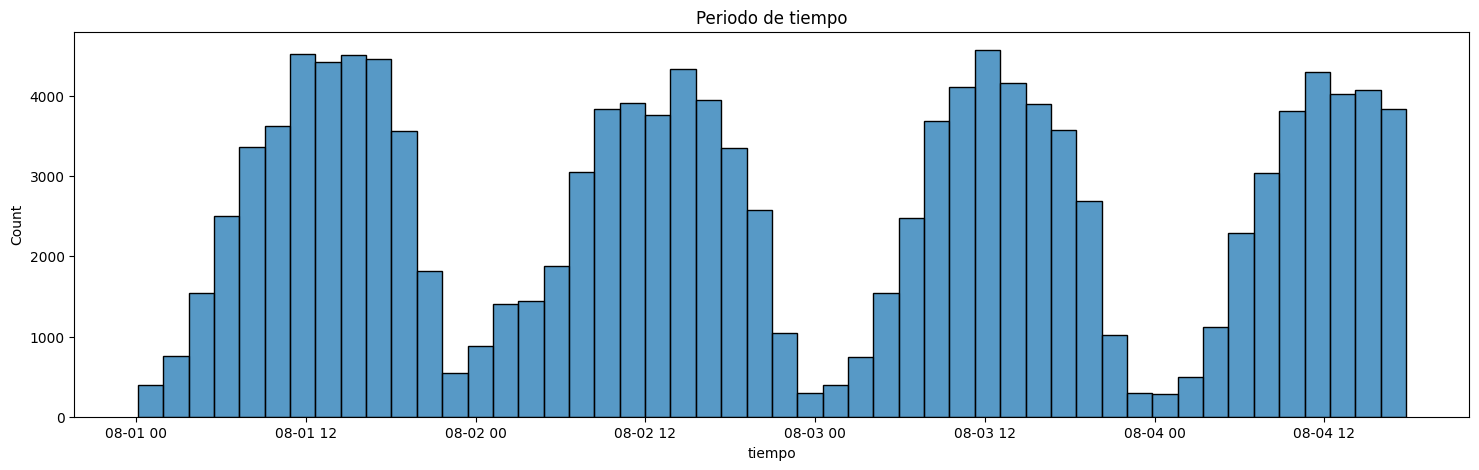

In [27]:
plt.figure(figsize=(18,5))
plt.title('Periodo de tiempo')
sns.histplot(df, x='tiempo');

¿Perdiste muchos eventos y usuarios al excluir los datos más antiguos?

In [28]:
logs.query('tiempo <= "2019-08-01"')

,nombre,dispositivo,tiempo,expid,fecha
0,pantalla_principal,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,pantalla_principal,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,pago_exitoso,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
3,carro_compra,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
4,pago_exitoso,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25
...,...,...,...,...,...
2821,pantalla_oferta,2413191300976302222,2019-07-31 23:54:55,247,2019-07-31
2822,pantalla_principal,5505110279185484837,2019-07-31 23:57:30,247,2019-07-31
2823,pantalla_principal,5505110279185484837,2019-07-31 23:57:42,247,2019-07-31
2824,pantalla_principal,5505110279185484837,2019-07-31 23:57:52,247,2019-07-31


Asegúrate de tener usuarios y usuarias de los tres grupos experimentales.

In [29]:
espids = df.groupby('expid')['dispositivo'].nunique()
espids

expid
246    2127
247    2167
248    2183
Name: dispositivo, dtype: int64

# Etapa 4 Estudiar el embudo de eventos

Observa qué eventos hay en los registros y su frecuencia de suceso. Ordénalos por frecuencia.

In [30]:
logs_246 = logs[logs['expid'] == 246].reset_index()
logs_246.head()

,index,nombre,dispositivo,tiempo,expid,fecha
0,0,pantalla_principal,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,1,pantalla_principal,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,6,pantalla_oferta,8351860793733343758,2019-07-25 14:50:42,246,2019-07-25
3,7,pantalla_principal,5682100281902512875,2019-07-25 20:14:37,246,2019-07-25
4,9,pantalla_principal,5407636962369102641,2019-07-26 03:35:12,246,2019-07-26


In [31]:
logs_247 = logs[logs['expid'] == 247].reset_index()
logs_247.head()

,index,nombre,dispositivo,tiempo,expid,fecha
0,8,pantalla_principal,1850981295691852772,2019-07-25 20:31:42,247,2019-07-25
1,10,pantalla_principal,948465712512390382,2019-07-26 05:33:34,247,2019-07-26
2,13,pantalla_principal,2140904690380565988,2019-07-26 07:22:12,247,2019-07-26
3,16,pantalla_principal,5839517684026830712,2019-07-26 11:43:41,247,2019-07-26
4,18,carro_compra,2575393697599976818,2019-07-26 13:49:05,247,2019-07-26


In [32]:
logs_248 = logs[logs['expid'] == 248].reset_index()
logs_248.head()

,index,nombre,dispositivo,tiempo,expid,fecha
0,2,pago_exitoso,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
1,3,carro_compra,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
2,4,pago_exitoso,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25
3,5,carro_compra,6217807653094995999,2019-07-25 11:48:43,248,2019-07-25
4,11,pantalla_principal,2547684315586332355,2019-07-26 06:50:26,248,2019-07-26


In [33]:
df.nombre.value_counts()

pantalla_principal    61960
pantalla_oferta       26014
carro_compra          24325
pago_exitoso          19259
tutorial                668
Name: nombre, dtype: int64

Encuentra la cantidad de usuarios y usuarias que realizaron cada una de estas acciones. Ordena los eventos por el número de usuarios y usuarias. Calcula la proporción de usuarios y usuarias que realizaron la acción al menos una vez

In [34]:
usuarios = df.groupby('nombre')['dispositivo'].nunique().sort_values(ascending=False).reset_index()
usuarios.columns = ['evento','cantidad']

In [35]:
usuarios['proporción'] = round(usuarios['cantidad']/df['dispositivo'].nunique()*100,2)
usuarios

,evento,cantidad,proporción
0,pantalla_principal,6330,97.73
1,pantalla_oferta,3795,58.59
2,carro_compra,3105,47.94
3,pago_exitoso,2936,45.33
4,tutorial,550,8.49


¿En qué orden crees que ocurrieron las acciones? ¿Todas son parte de una sola secuencia? No es necesario tenerlas en cuenta al calcular el embudo.

In [36]:
x = df.groupby('nombre')['dispositivo'].nunique().sort_values(ascending=False).reset_index()
x

,nombre,dispositivo
0,pantalla_principal,6330
1,pantalla_oferta,3795
2,carro_compra,3105
3,pago_exitoso,2936
4,tutorial,550


In [37]:
new_df = df.query('nombre != "tutorial"')
new_df.head()

,nombre,dispositivo,tiempo,expid,fecha
2827,pantalla_principal,3737462046622621720,2019-08-01 00:08:00,246,2019-08-01
2828,pantalla_principal,3737462046622621720,2019-08-01 00:08:55,246,2019-08-01
2829,pantalla_oferta,3737462046622621720,2019-08-01 00:08:58,246,2019-08-01
2830,pantalla_principal,1433840883824088890,2019-08-01 00:08:59,247,2019-08-01
2831,pantalla_principal,4899590676214355127,2019-08-01 00:10:15,247,2019-08-01


In [38]:
y = new_df.groupby('nombre')['dispositivo'].nunique().sort_values(ascending=False).reset_index()
y

,nombre,dispositivo
0,pantalla_principal,6330
1,pantalla_oferta,3795
2,carro_compra,3105
3,pago_exitoso,2936


Utiliza el embudo de eventos para encontrar la proporción de usuarios y usuarias que pasan de una etapa a la siguiente. (Por ejemplo, para la secuencia de eventos A → B → C, calcula la proporción de usuarios en la etapa B a la cantidad de usuarios en la etapa A y la proporción de usuarios en la etapa C a la cantidad en la etapa B).

In [39]:
usuario = new_df.pivot_table(
    index='dispositivo', 
    columns='nombre', 
    values='tiempo',
    aggfunc='min')

usuario.head()

nombre,carro_compra,pago_exitoso,pantalla_oferta,pantalla_principal
dispositivo,,,,
6922444491712477,2019-08-04 14:19:40,2019-08-04 14:19:40,2019-08-04 14:19:46,2019-08-04 14:19:33
7702139951469979,2019-08-02 14:28:45,2019-08-02 14:28:45,2019-08-01 04:29:56,2019-08-01 04:29:54
8740973466195562,NaT,NaT,2019-08-02 09:43:59,2019-08-02 09:16:48
9841258664663090,2019-08-03 10:52:15,2019-08-03 17:57:27,2019-08-03 10:49:42,2019-08-03 10:47:59
12692216027168046,NaT,NaT,NaT,2019-08-02 16:28:49


In [40]:
paso_1 = ~usuario['pantalla_principal'].isna()
paso_2 = paso_1 & (usuario['pantalla_oferta'] > usuario['pantalla_principal'])
paso_3 = paso_2 & (usuario['carro_compra'] > usuario['pantalla_oferta'])
paso_4 = paso_3 & (usuario['pago_exitoso'] > usuario['carro_compra'])

pantalla_principal = usuario[paso_1].shape[0]
pantalla_oferta = usuario[paso_2].shape[0]
carro_compra	 = usuario[paso_3].shape[0]
pago_exitoso = usuario[paso_4].shape[0]

print('Pantalla principal:', pantalla_principal)
print('Pantalla de oferta:', pantalla_oferta)
print('Carro de compra:', carro_compra)
print('Pagado:', pago_exitoso)

Pantalla principal: 6330
Pantalla de oferta: 3429
Carro de compra: 1393
Pagado: 311


In [41]:
new_df.head()

,nombre,dispositivo,tiempo,expid,fecha
2827,pantalla_principal,3737462046622621720,2019-08-01 00:08:00,246,2019-08-01
2828,pantalla_principal,3737462046622621720,2019-08-01 00:08:55,246,2019-08-01
2829,pantalla_oferta,3737462046622621720,2019-08-01 00:08:58,246,2019-08-01
2830,pantalla_principal,1433840883824088890,2019-08-01 00:08:59,247,2019-08-01
2831,pantalla_principal,4899590676214355127,2019-08-01 00:10:15,247,2019-08-01


In [42]:
expid_a = new_df[new_df.expid==246].groupby(['nombre','expid'])['dispositivo'].nunique().reset_index().sort_values(by='dispositivo',ascending=False)
expid_a

,nombre,expid,dispositivo
3,pantalla_principal,246,2076
2,pantalla_oferta,246,1276
0,carro_compra,246,1041
1,pago_exitoso,246,991


In [43]:
expid_b = new_df[new_df.expid==247].groupby(['nombre','expid'])['dispositivo'].nunique().reset_index().sort_values(by='dispositivo',ascending=False)
expid_b

,nombre,expid,dispositivo
3,pantalla_principal,247,2116
2,pantalla_oferta,247,1259
0,carro_compra,247,1031
1,pago_exitoso,247,962


In [44]:
expid_c = new_df[new_df.expid==248].groupby(['nombre','expid'])['dispositivo'].nunique().reset_index().sort_values(by='dispositivo',ascending=False)
expid_c

,nombre,expid,dispositivo
3,pantalla_principal,248,2138
2,pantalla_oferta,248,1260
0,carro_compra,248,1033
1,pago_exitoso,248,983


In [45]:
embudo_expid = pd.concat([expid_a, expid_b, expid_c])
embudo_expid

,nombre,expid,dispositivo
3,pantalla_principal,246,2076
2,pantalla_oferta,246,1276
0,carro_compra,246,1041
1,pago_exitoso,246,991
3,pantalla_principal,247,2116
2,pantalla_oferta,247,1259
0,carro_compra,247,1031
1,pago_exitoso,247,962
3,pantalla_principal,248,2138
2,pantalla_oferta,248,1260


In [46]:
fig=px.funnel(embudo_expid,x='dispositivo',y='nombre',color='expid')
fig.update_layout(title='Embudo por número de usuarios en cada evento', title_x=0.55)
fig.update_layout(width=1000,height=500)
fig.show()

¿En qué etapa pierdes más usuarios y usuarias?

In [47]:
embudo_expid_246 = embudo_expid[embudo_expid['expid']==246]

In [48]:
fig = go.Figure(go.Funnel(y=embudo_expid_246['nombre'], 
                          x=embudo_expid_246['dispositivo'], textinfo = "value+percent initial",
                          opacity = 0.65, marker = {"color": "black"}))
fig.update_layout(width=1000,height=500)
fig.update_layout(title='Expid 246', title_x=0.55)
fig.show()

In [49]:
embudo_247 = embudo_expid[embudo_expid['expid']==247]

In [50]:
fig = go.Figure(go.Funnel(y=embudo_247['nombre'], 
                          x=embudo_247['dispositivo'], textinfo = "value+percent initial",
                          opacity = 0.65, marker = {"color": "blue"}))
fig.update_layout(width=1000,height=500)
fig.update_layout(title='Expid 247', title_x=0.55)
fig.show()

In [51]:
embudo_248 = embudo_expid[embudo_expid['expid']==248]

In [52]:
fig = go.Figure(go.Funnel(y=embudo_248['nombre'], 
                          x=embudo_248['dispositivo'], textinfo = "value+percent initial",
                          opacity = 0.65, marker = {"color": "red"}))
fig.update_layout(width=1000,height=500)
fig.update_layout(title='Expid 248', title_x=0.55)
fig.show()

Conclusión 

- Al observar los embudos de cada grupo, podemos decir que la etapa en la que más usuarios se pierden es entre la pantalla principal y la pantalla de oferta, con alrededor de un 40% de los usuarios, abandonan el embudo, esto se repite en los 3 grupos de datos.

- El paso con la menor reducción de usuarios es entre el carro compra y la pantalla de pago exitoso, con alrededor de un 3%.

¿Qué porcentaje de usuarios y usuarias hace todo el viaje desde su primer evento hasta el pago?

In [53]:
usuarios_finales = new_df.groupby(['nombre'])['dispositivo'].nunique().sort_values(ascending=False).reset_index()

In [54]:
usuarios_finales['porcentaje'] = usuarios_finales['dispositivo'].pct_change()
usuarios_finales

,nombre,dispositivo,porcentaje
0,pantalla_principal,6330,NaN
1,pantalla_oferta,3795,-0.400474
2,carro_compra,3105,-0.181818
3,pago_exitoso,2936,-0.054428


In [55]:
fig = go.Figure(go.Funnel(
    y = usuarios_finales['nombre'],
    x = usuarios_finales['dispositivo'],
    textposition = "inside",
    textinfo = "value+percent initial",
    opacity = 0.65, marker = {"color": ["deepskyblue", "lightsalmon", "tan", "teal", "black"],
    "line": {"width": [4, 2, 2, 3, 1, 1], "color": ["wheat", "wheat", "blue", "wheat", "wheat"]}},
    connector = {"line": {"color": "royalblue", "dash": "dot", "width": 3}})
    )
fig.update_layout(width=1000,height=500)   
fig.update_layout(title='Embudo total de datos', title_x=0.55)
fig.show()

Conclusión

Como podemos ver en el grafico, del 100% de los datos podemos decir que alrededor de un 48% de ellos llegan a recorren todos los eventos, es decir llegan hasta pago exitoso, que es el ultimo evento de la lista 

# Paso 5. Estudiar los resultados del experimento

¿Cuántos usuarios y usuarias hay en cada grupo?

In [56]:
grupos = new_df.groupby('expid')['dispositivo'].nunique()
grupos

expid
246    2127
247    2165
248    2183
Name: dispositivo, dtype: int64

Tenemos dos grupos de control en el test A/A, donde comprobamos nuestros mecanismos y cálculos. Observa si hay una diferencia estadísticamente significativa entre las muestras 246 y 247.

In [57]:
test = new_df.pivot_table(index='nombre', columns='expid',values='dispositivo',aggfunc='nunique').reset_index()
test

expid,nombre,246,247,248
0,carro_compra,1041,1031,1033
1,pago_exitoso,991,962,983
2,pantalla_oferta,1276,1259,1260
3,pantalla_principal,2076,2116,2138


Selecciona el evento más popular. En cada uno de los grupos de control, encuentra la cantidad de usuarios y usuarias que realizaron esta acción. Encuentra su proporción. Comprueba si la diferencia entre los grupos es estadísticamente significativa. Repite el procedimiento para todos los demás eventos (ahorrarás tiempo si creas una función especial para esta prueba). ¿Puedes confirmar que los grupos se dividieron correctamente?

In [58]:
fig = go.Figure(go.Funnel(y=embudo_expid_246['nombre'], 
                          x=embudo_expid_246['dispositivo'], textinfo = "value+percent initial",
                          opacity = 0.65, marker = {"color": "black"}))
fig.update_layout(width=1000,height=500)
fig.update_layout(title='Expid 246', title_x=0.55)
fig.show()

In [59]:
fig = go.Figure(go.Funnel(y=embudo_247['nombre'], 
                          x=embudo_247['dispositivo'], textinfo = "value+percent initial",
                          opacity = 0.65, marker = {"color": "blue"}))
fig.update_layout(width=1000,height=500)
fig.update_layout(title='Expid 247', title_x=0.55)
fig.show()

El evento principal es 'Pantalla Principal' con el 100% de los datos selecionados, no hay mayor diferencia entre los grupos y sus diferentes eventos todos tienen una proporcionabilidad muy similar

A/A test - 246/247

**H0 - Hay una diferencia significativa entre las proporciones de los grupos 246 y 247.**

**H1 - No hay razón para considerar que las proporciones de los grupos 246 y 247 sean diferentes.**

In [60]:
new_df.head()

,nombre,dispositivo,tiempo,expid,fecha
2827,pantalla_principal,3737462046622621720,2019-08-01 00:08:00,246,2019-08-01
2828,pantalla_principal,3737462046622621720,2019-08-01 00:08:55,246,2019-08-01
2829,pantalla_oferta,3737462046622621720,2019-08-01 00:08:58,246,2019-08-01
2830,pantalla_principal,1433840883824088890,2019-08-01 00:08:59,247,2019-08-01
2831,pantalla_principal,4899590676214355127,2019-08-01 00:10:15,247,2019-08-01


In [61]:
def check_hypothesis(group1,group2,event,alpha=0.05):
    
    test = new_df.pivot_table(index='nombre', columns='expid',values='dispositivo',aggfunc='nunique').reset_index()

    success1=test[test.nombre==event][group1].iloc[0]
    success2=test[test.nombre==event][group2].iloc[0]
    
    trials1=new_df[new_df.expid==group1]['dispositivo'].nunique()
    trials2=new_df[new_df.expid==group2]['dispositivo'].nunique()
    
    
# proporción de éxito en el primer grupo:
    p1 = success1/trials1

# proporción de éxito en el segundo grupo:
    p2 = success2/trials2

# proporción de éxito en el conjunto de datos combinado:
    p_combined = (success1 + success2) / (trials1 + trials2)

# la diferencia entre las proporciones de los conjuntos de datos
    difference = p1 - p2
# calcular la estadística en desviaciones estándar de la distribución normal estándar
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials1 + 1/trials2))

# establecer la distribución normal estándar (media 0, desviación estándar 1)
    distr = st.norm(0, 1)
# calcular la estadística en desviaciones estándar de la distribución normal estándar

    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('p-value: ', p_value)

    if (p_value < alpha):
        print("Se rechaza hipotesis nula por", event,"de los grupos", group1,group2)
    else:
        print("No se pudo rechazar la hipótesis nula de",event,"de los grupos", group1,group2 )
    

In [62]:
for i in test.nombre.unique():
    check_hypothesis(246,247,i,alpha=0.05)
    print('-'*50)
    print()

p-value:  0.38656512715324753
No se pudo rechazar la hipótesis nula de carro_compra de los grupos 246 247
--------------------------------------------------

p-value:  0.15590181589824414
No se pudo rechazar la hipótesis nula de pago_exitoso de los grupos 246 247
--------------------------------------------------

p-value:  0.22076889610784667
No se pudo rechazar la hipótesis nula de pantalla_oferta de los grupos 246 247
--------------------------------------------------

p-value:  0.7703099511295792
No se pudo rechazar la hipótesis nula de pantalla_principal de los grupos 246 247
--------------------------------------------------



In [63]:
for i in test.nombre.unique():
    check_hypothesis(246,247,i,alpha=0.01)
    print('-'*50)
    print()

p-value:  0.38656512715324753
No se pudo rechazar la hipótesis nula de carro_compra de los grupos 246 247
--------------------------------------------------

p-value:  0.15590181589824414
No se pudo rechazar la hipótesis nula de pago_exitoso de los grupos 246 247
--------------------------------------------------

p-value:  0.22076889610784667
No se pudo rechazar la hipótesis nula de pantalla_oferta de los grupos 246 247
--------------------------------------------------

p-value:  0.7703099511295792
No se pudo rechazar la hipótesis nula de pantalla_principal de los grupos 246 247
--------------------------------------------------



Todas las pruebas de las diferentes etapas no rechazan la hipótesis nula

Por lo tanto, se refuerza la afirmación de que la diferencia entre los grupos 246 y 247 no es estadísticamente significativa con valores alfa de 0,05 y 0,01.

Haz lo mismo para el grupo con fuentes alteradas. Compara los resultados con los de cada uno de los grupos de control para cada evento de forma aislada. Compara los resultados con los resultados combinados de los grupos de control. ¿Qué conclusiones puedes sacar del experimento?

In [64]:
fig = go.Figure(go.Funnel(y=embudo_248['nombre'], 
                          x=embudo_248['dispositivo'], textinfo = "value+percent initial",
                          opacity = 0.65, marker = {"color": "red"}))
fig.update_layout(width=1000,height=500)
fig.update_layout(title='Expid 248', title_x=0.55)
fig.show()

A1/B test - 246/248

**H0 - Hay una diferencia significativa entre las proporciones de los grupos 246 y 248.**

**H1 - No hay razón para considerar que las proporciones de los grupos 246 y 248 sean diferentes.**

In [65]:
for i in test.nombre.unique():
    check_hypothesis(246,248,i,alpha=0.05)
    print('-'*50)
    print()

p-value:  0.2866514194055174
No se pudo rechazar la hipótesis nula de carro_compra de los grupos 246 248
--------------------------------------------------

p-value:  0.3035770546539911
No se pudo rechazar la hipótesis nula de pago_exitoso de los grupos 246 248
--------------------------------------------------

p-value:  0.12971320729983415
No se pudo rechazar la hipótesis nula de pantalla_oferta de los grupos 246 248
--------------------------------------------------

p-value:  0.45438851355631704
No se pudo rechazar la hipótesis nula de pantalla_principal de los grupos 246 248
--------------------------------------------------



In [66]:
for i in test.nombre.unique():
    check_hypothesis(246,248,i,alpha=0.01)
    print('-'*50)
    print()

p-value:  0.2866514194055174
No se pudo rechazar la hipótesis nula de carro_compra de los grupos 246 248
--------------------------------------------------

p-value:  0.3035770546539911
No se pudo rechazar la hipótesis nula de pago_exitoso de los grupos 246 248
--------------------------------------------------

p-value:  0.12971320729983415
No se pudo rechazar la hipótesis nula de pantalla_oferta de los grupos 246 248
--------------------------------------------------

p-value:  0.45438851355631704
No se pudo rechazar la hipótesis nula de pantalla_principal de los grupos 246 248
--------------------------------------------------



Todas las pruebas de las diferentes etapas no rechazan la hipótesis nula.

Por lo tanto, se refuerza la afirmación de que la diferencia entre los grupos, 246 y 248, no es estadísticamente significativa con valores alfa de 0,05 y 0,01.

A2/B test - 247/248

**H0 - Hay una diferencia significativa entre las proporciones de los grupos 247 y 248.**

**H1 - No hay razón para considerar que las proporciones de los grupos 247 y 248 sean diferentes.**

In [67]:
for i in test.nombre.unique():
    check_hypothesis(247,248,i,alpha=0.05)
    print('-'*50)
    print()

p-value:  0.8424501570369793
No se pudo rechazar la hipótesis nula de carro_compra de los grupos 247 248
--------------------------------------------------

p-value:  0.6928978328465163
No se pudo rechazar la hipótesis nula de pago_exitoso de los grupos 247 248
--------------------------------------------------

p-value:  0.7720917771073219
No se pudo rechazar la hipótesis nula de pantalla_oferta de los grupos 247 248
--------------------------------------------------

p-value:  0.6471795136069378
No se pudo rechazar la hipótesis nula de pantalla_principal de los grupos 247 248
--------------------------------------------------



In [68]:
for i in test.nombre.unique():
    check_hypothesis(247,248,i,alpha=0.01)
    print('-'*50)
    print()

p-value:  0.8424501570369793
No se pudo rechazar la hipótesis nula de carro_compra de los grupos 247 248
--------------------------------------------------

p-value:  0.6928978328465163
No se pudo rechazar la hipótesis nula de pago_exitoso de los grupos 247 248
--------------------------------------------------

p-value:  0.7720917771073219
No se pudo rechazar la hipótesis nula de pantalla_oferta de los grupos 247 248
--------------------------------------------------

p-value:  0.6471795136069378
No se pudo rechazar la hipótesis nula de pantalla_principal de los grupos 247 248
--------------------------------------------------



Todas las pruebas de las diferentes etapas no rechazan la hipótesis nula

Por lo tanto, se refuerza la afirmación de que la diferencia entre los grupos, 247 y 248, no es estadísticamente significativa con valores alfa de 0,05 y 0,01.

¿Qué nivel de significación has establecido para probar las hipótesis estadísticas mencionadas anteriormente? Calcula cuántas pruebas de hipótesis estadísticas has realizado. Con un nivel de significancia estadística de 0.1, uno de cada 10 resultados podría ser falso. ¿Cuál debería ser el nivel de significación? Si deseas cambiarlo, vuelve a ejecutar los pasos anteriores y comprueba tus conclusiones.

A/B test - (246+247)A/(248)B

**H0 - Hay una diferencia significativa entre las proporciones del grupo de control (246 y 247) y el grupo de prueba 248.**

**H1 - No hay razón para considerar que las proporciones del grupo de control (246 y 247) y el grupo de prueba 248 sean diferentes.**

In [69]:
def combined_hypothesis(group1,group2,group3,event,alpha=0.05):
      

    success1=test[test.nombre==event][group1].iloc[0]+test[test.nombre==event][group2].iloc[0]
    success2=test[test.nombre==event][group3].iloc[0]
    
    trials1=new_df[new_df.expid==group1]['dispositivo'].nunique()+new_df[new_df.expid==group2]['dispositivo'].nunique()
    trials2=new_df[new_df.expid==group3]['dispositivo'].nunique()
    
    
    # proporción de éxito en el primer grupo:
    p1 = success1/trials1

    # proporción de éxito en el segundo grupo:
    p2 = success2/trials2

    # proporción de éxito en el conjunto de datos combinado:
    p_combined = (success1 + success2) / (trials1 + trials2)

    # la diferencia entre las proporciones de los conjuntos de datos
    difference = p1 - p2
    # calcular la estadística en desviaciones estándar de la distribución normal estándar
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials1 + 1/trials2))

    # establecer la distribución normal estándar (media 0, desviación estándar 1)
    distr = st.norm(0, 1)
    # calcular la estadística en desviaciones estándar de la distribución normal estándar

    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('p-value: ', p_value)

    if (p_value < alpha):
        print("Se Rechaza la hipótesis nula por", event," De grupos", group1,'+',group2,'y grupo',group3,', parece ser estadísticamente diferente')
    else:
        print("No se pudo rechazar la hipótesis nula por",event,"De grupos", group1,'+',group2,'y grupo',group3,', parece ser estadísticamente equivalente')

In [70]:
for i in test.nombre.unique():
    combined_hypothesis(246,247,248,i,alpha=0.05)
    print('-'*50)
    print()

p-value:  0.4668155894069932
No se pudo rechazar la hipótesis nula por carro_compra De grupos 246 + 247 y grupo 248 , parece ser estadísticamente equivalente
--------------------------------------------------

p-value:  0.7175032356482136
No se pudo rechazar la hipótesis nula por pago_exitoso De grupos 246 + 247 y grupo 248 , parece ser estadísticamente equivalente
--------------------------------------------------

p-value:  0.2990348715739395
No se pudo rechazar la hipótesis nula por pantalla_oferta De grupos 246 + 247 y grupo 248 , parece ser estadísticamente equivalente
--------------------------------------------------

p-value:  0.4899555095198389
No se pudo rechazar la hipótesis nula por pantalla_principal De grupos 246 + 247 y grupo 248 , parece ser estadísticamente equivalente
--------------------------------------------------



In [71]:
for i in test.nombre.unique():
    combined_hypothesis(246,247,248,i,alpha=0.01)
    print('-'*50)
    print()

p-value:  0.4668155894069932
No se pudo rechazar la hipótesis nula por carro_compra De grupos 246 + 247 y grupo 248 , parece ser estadísticamente equivalente
--------------------------------------------------

p-value:  0.7175032356482136
No se pudo rechazar la hipótesis nula por pago_exitoso De grupos 246 + 247 y grupo 248 , parece ser estadísticamente equivalente
--------------------------------------------------

p-value:  0.2990348715739395
No se pudo rechazar la hipótesis nula por pantalla_oferta De grupos 246 + 247 y grupo 248 , parece ser estadísticamente equivalente
--------------------------------------------------

p-value:  0.4899555095198389
No se pudo rechazar la hipótesis nula por pantalla_principal De grupos 246 + 247 y grupo 248 , parece ser estadísticamente equivalente
--------------------------------------------------



# Conclusiones

- Eliminamos el período del 25 de julio de 2019 al 31 de julio de 2019 ya que hubo una cantidad muy baja de observaciones y lo dejamos con la primera semana de agosto (del 1 de agosto al 7 de agosto de 2019).

- El número promedio de eventos por usuario es de 32 eventos en comparación con el número de mediana de eventos por usuario que es de 20.

- Al observar los embudos de cada grupo, se torna evidente que la etapa en la que más usuarios perdemos es entre la aparición de la pantalla principal y la aparición de la pantalla de oferta, casi el 40% de los usuarios abandonan el embudo en este punto, y es válido para todos los grupos que tenemos en los datos.

- En cuanto a la proporción de usuarios que hacen todo el viaje desde su primer paso en el embudo, aparecen en la pantalla principal, hasta el último, pago exitoso, es casi el 48% en todos los grupos.

- Con base en los resultados del experimento A/A/B, se concluyó que no hubo diferencias estadísticamente significativas en las proporciones de eventos en ninguno de los grupos analizados con niveles de significación alfa de 0,05 o 0,01.

- Eso significa que la diferencia en los grupos no afectó el comportamiento de los usuarios y no podemos afirmar que uno de los grupos sea mejor que el otro.